## Rooftop Solar market intervention, Erie County, NY
## Random walk on the graph of the Census tracts

#### Tianmu Zhang, Torsten Schunder
#### University at Buffalo  
- tianmu.zhang863@gmail.com
- torsten.schunder@gmail.com

#### Random walk on the graph, based on contigency of CT's.
#### The goal is to compare the different ways of selecting the intervention locations.
#### Assumption: Assigning different initial locations (starting distributions) of the random walk, the result of assymmetry will be different

In [1]:
import pandas as pd
import numpy as np

import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats as spstt
from sklearn.preprocessing import StandardScaler

import contextily as ctx

import os

# %matplotlib inline
# %matplotlib agg

### Read data files

In [2]:
# read pre-calculated distance file
dat = pd.read_csv('./ErieDiff0010rook_queen_test.csv')

# drop nan due to the out-of-county edges, CT's that are adjancent with CT's not in Erie County
dist_main_ls = dat.dropna()

# generate a list for node, so the order of CT's is fixed,
# then can be used to create adjacency matrix,
# will use .index() subsequently to query the index
nod_set = set(list(dist_main_ls.dropna()['V1'].values.astype(int))\
              +list(dist_main_ls.dropna()['V2'].values.astype(int)))
nod_ls = list(nod_set)

# below are the files for the GeoID's for intial distribution in the random walk
# read Katz file, determine the initial distribution for random walk
init_dis = pd.read_csv('./Maps/Katz.csv', index_col='GEOID')
# read highest income ID file
hi_income_id = pd.read_csv('./Maps/HighestIncome.csv', index_col='TRTID10')

In [3]:
# read geojson
gj = gpd.read_file('./../geojson/Erie.geojson', index_col='GEOID')
gj_g = gj[['GEOID', 'geometry']] # we only need these two columns for the purpose of plotting
gj_g = gj_g.set_index('GEOID') # re-set the index of the DataFrame

In [4]:
# create geopandas DataFrame for plot maps
# list for geoID and polygon, 
# The following is to remove the special CT's that exist in the GeoJSON but not in the data
# Special CT's are, for example, the ones contain university dorms, and such.
geo_list = []

for rr in nod_ls:
    geo_list.append(gj_g.loc[str(rr),'geometry'])

# create a new GoeDataFrame, no outliers        
gj_g_woo = gpd.GeoDataFrame(index=nod_ls, geometry=geo_list)

In [5]:
# test plot and check if the order of the CT's in
# the GeoJSON DataFrame is the same as nod_ls
gj_g_woo.index.tolist() == nod_ls#.plot()

True

### Set up the initial vector, based on chosen CT's
### Choose one from the following two cells, the first cell get the CT ID's by the colums
### The second cell get the CT ID by setting a minimum number of CT's in one cluster

Three different initial distributions  
- 15 highest income CT's
- 15 highest Katz centrality CT's
- 15 selected market invertention CT's


15 is the number of clusters we chose in the spectral clustering

In [6]:
# set up the initial vectors of the random walk
# this dic store the indices of starting elements of the vector
rdwlk = {
    'hiinc':[nod_ls.index(idd) for idd in hi_income_id.index.tolist()],
    'hikatz':[nod_ls.index(idd) for idd in init_dis['15Highest'].dropna().index.tolist()],
    'interven':[nod_ls.index(idd) for idd in init_dis['15intervention'].dropna().index.tolist()]}

### build the graph and transition matrix

In [7]:
# take queen only
dist_main_ls = dist_main_ls[dist_main_ls['Queen']==0]

# for the random walk, we use the maha. distance of EriePer2010test2 for the weights
dis_type = 'maha'
sel_ppt = 'EriePer2010test2'

# the standard deviation of all of the edges
simi_std = dist_main_ls[sel_ppt+'_'+dis_type].dropna().std()

# Adjacency/Weight Matrix
A_mat = np.zeros([len(nod_set), len(nod_set)])
# Binary adjancey, for the use as weight matrix for Moran's I spatial autocorrelation
A_mat_b = np.zeros([len(nod_set), len(nod_set)])

# iterate all of the edges in the edge and dist. DataFrame
for idx, rr in dist_main_ls.iterrows():
    try: # The edge list contains duplicates, and NaN, so use "try" to filter the NaN ones.
        # the current edge, a tuple
        crt_edg = (nod_ls.index(int(rr[['V1', 'V2']][0])), nod_ls.index(int(rr[['V1', 'V2']][1])))
        
        # assign edge weights based on distance measures,
        # although all types here are treated same, we still separate the cases,
        # because it will be easier for future if modifaiction of one type of distance measures
        # is needed.
        if dis_type == 'eucli': # Euclidean
            A_mat[crt_edg[0], crt_edg[1]] =\
            np.exp((-1./(2.*simi_std**2))*(rr[sel_ppt+'_'+dis_type]**2))
        elif dis_type == 'cos': # Cosine similarity
            # Cosine similarity can be inverted and directly assign to edge weights,
            # bu here we use the same as other distance types.
            A_mat[crt_edg[0], crt_edg[1]] =\
            np.exp((-1./(2.*simi_std**2))*(rr[sel_ppt+'_'+dis_type]**2))
        elif dis_type == 'pca': # PCA reduced
            A_mat[crt_edg[0], crt_edg[1]] =\
            np.exp((-1./(2.*simi_std**2))*(rr[sel_ppt+'_'+dis_type]**2))
        elif dis_type == 'maha':
            A_mat[crt_edg[0], crt_edg[1]] =\
            np.exp((-1./(2.*simi_std**2))*(rr[sel_ppt+'_'+dis_type]**2))
        # make the matrix symmetric
        A_mat[crt_edg[1], crt_edg[0]] = A_mat[crt_edg[0], crt_edg[1]]
        # assign '1' to the binary adjancency matrix
        A_mat_b[crt_edg[0], crt_edg[1]] = 1
        A_mat_b[crt_edg[1], crt_edg[0]] = A_mat_b[crt_edg[0], crt_edg[1]]
    except ValueError:
        pass

### From Adjancency matrix to transition probablity matrix
### Self transition for each node can be set

In [8]:
self_lp = .8 # the ratio of the weight of the self loop to the sum of theout-going edges
D_mat = np.diag(np.sum(A_mat, axis=1)) # Degree matrix
A_mat_ = A_mat*(1-self_lp) + D_mat*self_lp # distribute the probability between neighbors and itself
D_mat_inv = np.diag(1./np.sum(A_mat_, axis=1)) # Degree matrix
# np.dot(D_mat, D_mat_inv) # Check if is inverse
# M_mat = np.dot(D_mat_inv, A_mat)
M_mat_ = np.dot(D_mat_inv, A_mat_) # normalize, so it becomes a probability distribution
# M_mat.sum(1) # check see if sum up to 1

### vector multiply with transition matrix

In [9]:
# dic. for storing the probability distribution at every step of the walk
rdwlk_pbb = {}

# iterate for three initial distributions
for kk, vv in rdwlk.items():
    # initial distribution
    P0_ = np.array([ 1.0 if idd in vv else 0.0 for idd in range(len(nod_ls))])/len(vv)
    
    # list for storing P at every step of the walk, with the step=0
    Ps_ls = [P0_]
    
    # walk this many steps
    for ii in range(10000):
        Ps_ls.append(np.dot(M_mat_.T, np.array(Ps_ls[-1])))
    # save the probability of steps to the dic.    
    rdwlk_pbb[kk] = Ps_ls
    
    # also save to xlsx, user to determine the number of steps to be saved
    pd.DataFrame(data=np.array(Ps_ls[:2000]).T, index=nod_ls, 
                 columns=[ii for ii in range(2000)]).to_excel('./randwalk'+kk+'.xlsx')

### Plotting with mpl. Two plotting scheme, first is just for a quick check  
- scatter plot in mpl, each CT is a dot
- geoPandas

### the mpl scatter part is obselete, can be skipped

In [69]:
# read the coordinates of the CT's, for plotting
erie_ctr = pd.read_csv('./../../For Website/Eriecentr.csv', index_col='GEOID10', usecols=['Long', 'Lat', 'GEOID10'])

In [10]:
subplt_cnt = 1
fig1 = plt.figure(figsize=(8, 20))
for ii in range(5):
    ax11 = fig1.add_subplot(5,2,2*ii+1)
    ax12 = fig1.add_subplot(5,2,2*ii+2)
    cc = Ps_lo[ii*10]
    for nd, vl in zip(nod_ls, cc/max(cc)):
        ax11.scatter(*erie_ctr.loc[nd], c=[cm.rainbow(vl)], s=10)
        
    cc = Ps_hi[ii*10]
    for nd, vl in zip(nod_ls, cc/max(cc)):
        ax12.scatter(*erie_ctr.loc[nd], c=[cm.rainbow(vl)], s=10)
#     subplt_cnt+1

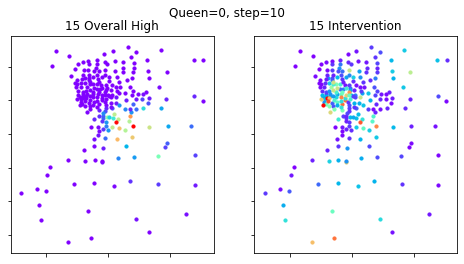

In [10]:
fig2 = plt.figure(figsize=(8, 4))
ax21 = fig2.add_subplot(1,2,1)
ax22 = fig2.add_subplot(1,2,2)
for ii in range(10,11):
    cc = Ps_lo[ii*1]
    for nd, vl in zip(nod_ls, cc/max(cc)):
        ax21.scatter(*erie_ctr.loc[nd], c=[cm.rainbow(vl)], s=10)
        
    cc = Ps_hi[ii*1]
    for nd, vl in zip(nod_ls, cc/max(cc)):
        ax22.scatter(*erie_ctr.loc[nd], c=[cm.rainbow(vl)], s=10)
#     ax21.set_title(f'low Katz: {lo_ctr_id}')
#     ax22.set_title(f'high Katz: {hi_ctr_id}')
#     ax21.set_title(f'low Katz: {sum(P0_hi!=0)} low')
#     ax22.set_title(f'high Katz: {sum(P0_hi!=0)} high')
    ax21.set_title(f'15 Overall High')
    ax22.set_title(f'15 Intervention')
    ax21.set_xticklabels([])
    ax21.set_yticklabels([])
    ax22.set_xticklabels([])
    ax22.set_yticklabels([])
    fig2.suptitle(f'Queen=0, step={ii}')
#     fig2.savefig(f'./figs/rand_walk/EPtest2/{ii}.png')
#     fig2.savefig(f'./figs/rand_walk/EPtest2_15hiloQ/{ii}.png')
#     fig2.savefig(f'./figs/rand_walk/EPtest2_15hi15inter/{ii}.png')
#     fig2.savefig(f'./figs/rand_walk/self_loop/EPtest2_15hi15inter/{ii}.png')
#     ax21.clear()
#     ax22.clear()

### Plotting using GeoPandas

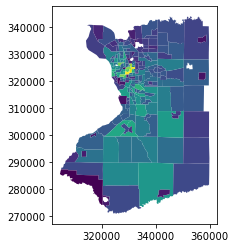

In [12]:
# quick test
cc = Ps_ls[100]
cc = cc/max(cc)
# gj_g_woo['clr_val'] = cc
# sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0., vmax=1.))
gj_g_woo.plot(column=cc, cmap='viridis')

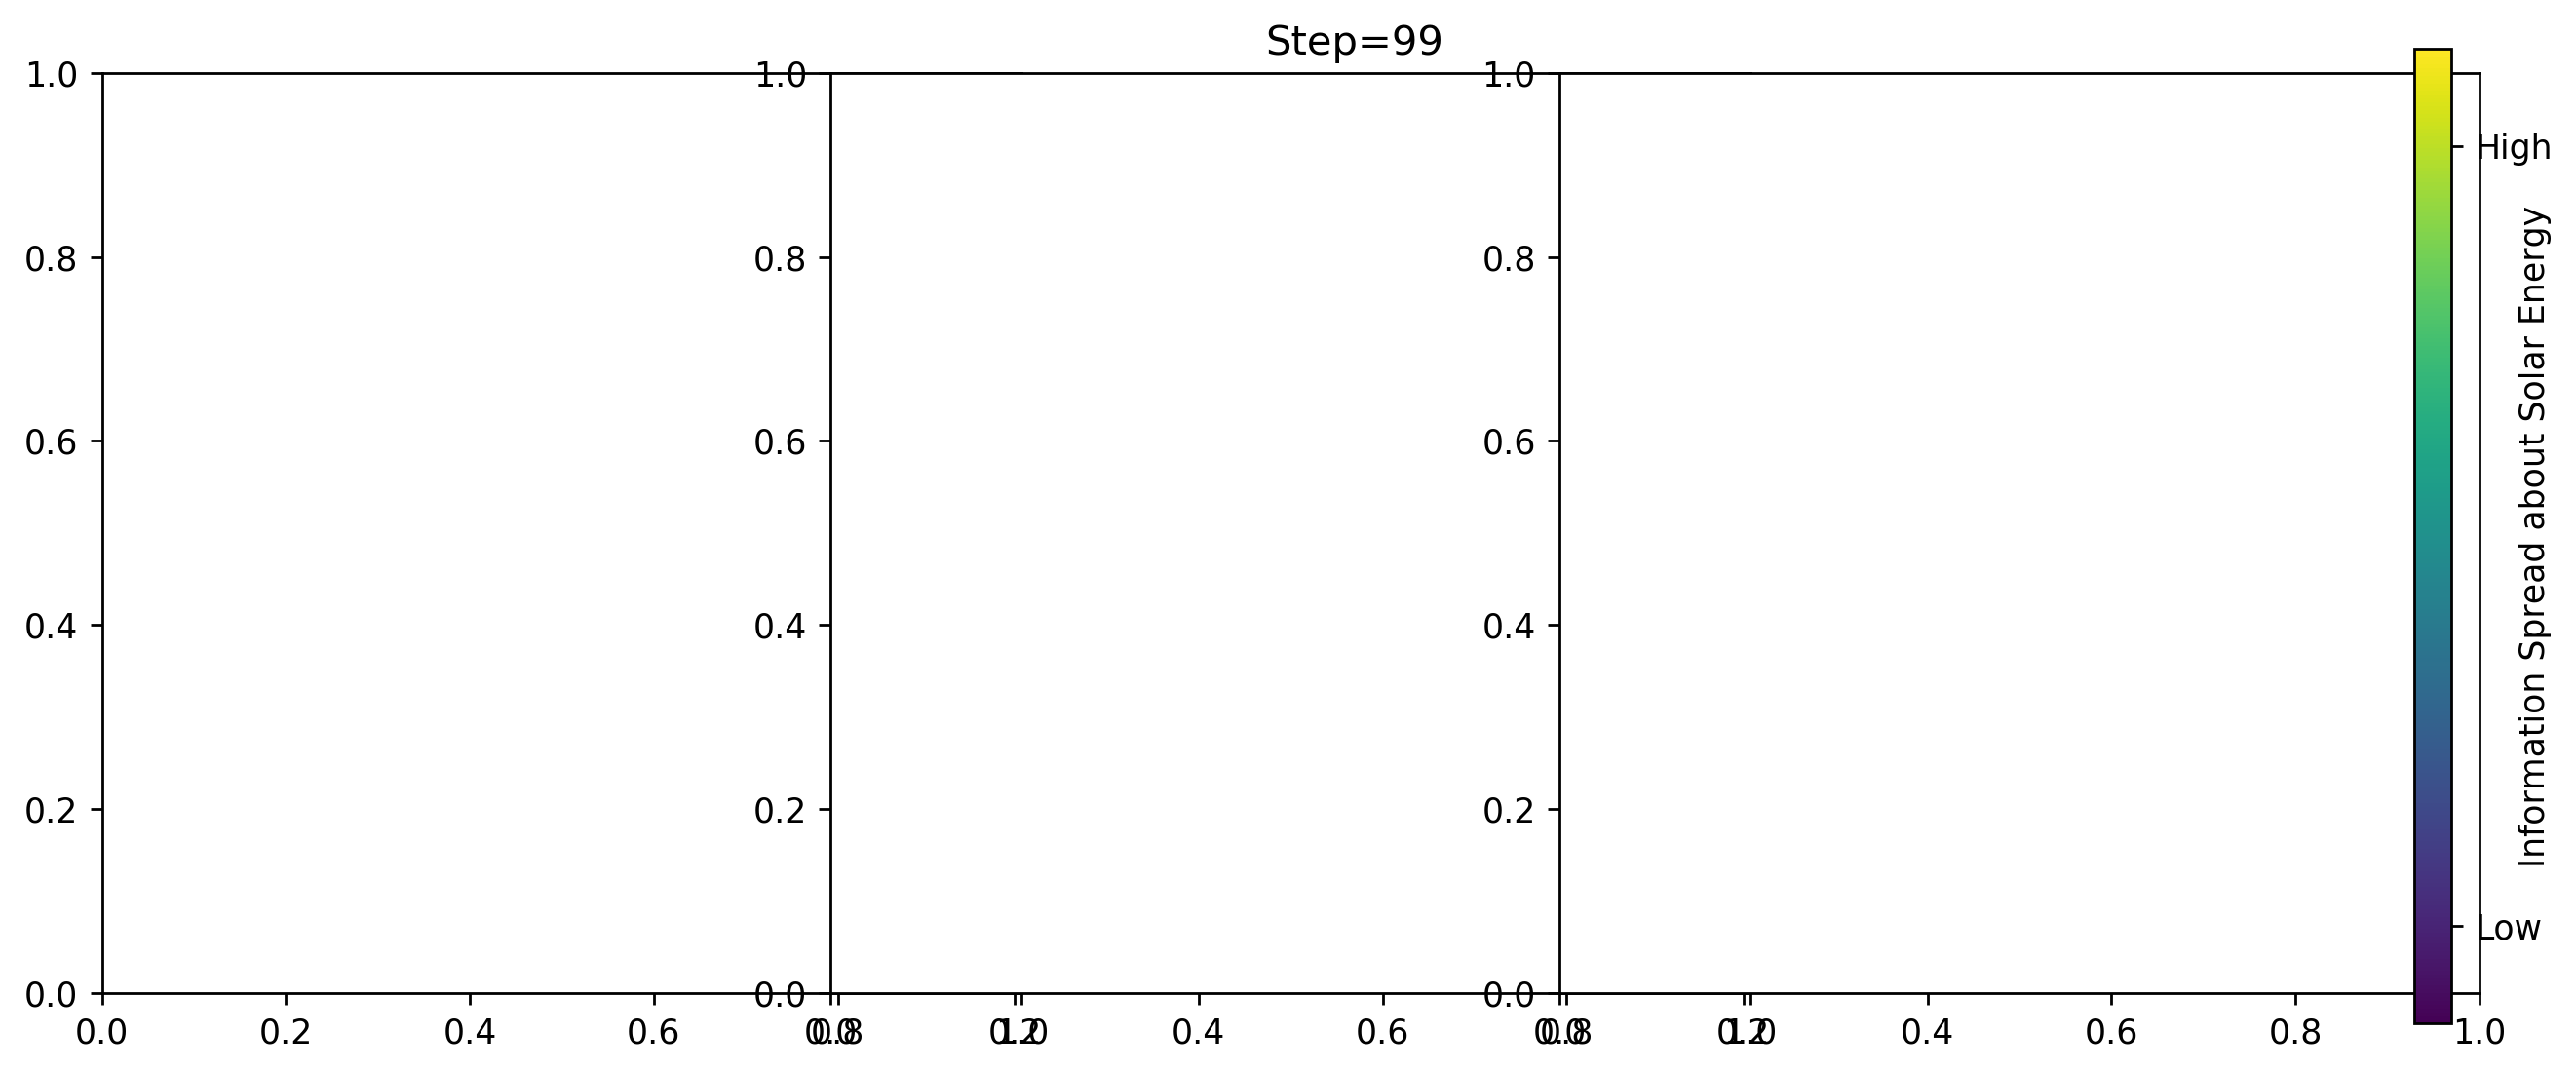

In [10]:
fig3 = plt.figure(figsize=(15, 5), dpi=250)
ax31 = fig3.add_subplot(1,3,1)
ax32 = fig3.add_subplot(1,3,2)
ax33 = fig3.add_subplot(1,3,3)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0., vmax=1.))
sm.set_array([])

fig3.subplots_adjust(right=0.9)
cbar_ax = fig3.add_axes([0.82, 0.1, 0.01, 0.8])
cbr = fig3.colorbar(sm, cax=cbar_ax, ticks=[0.1, .9], )
cbr.set_label('Information Spread about Solar Energy', labelpad=-10)
cbar_ax.set_yticklabels(['Low', 'High'])
# cbar_ax.axis('off')
fig3.subplots_adjust(wspace=-.47)

# iterate frames
for ii in range(0,100):
# for ii in range(0,1): # for figure test
    ax31.axis('off')
    ax32.axis('off')
    ax33.axis('off')
#     ax31.set_title(f'Selected Intervention Targets:\n Highest centrality in Erie County', 
#                    y=-0.1)
#     ax32.set_title('Selected Intervention Targets:\n Highest Household Income\n in Erie County', 
#                    y=-0.15)
#     ax33.set_title(f'Selected Intervention Targets:\n Highest centrality within\n Population Cluster',
#                   y=-0.15)
    ax31.set_title(f'Scenario 1, Intervention Targets:\n Highest centrality in Erie County', 
                   y=-0.1)
    ax32.set_title(f'Scenario 2, Intervention Targets:\n Highest Household Income\n in Erie County', 
                   y=-0.15)
    ax33.set_title(f'Scenario 3, Intervention Targets:\n Highest centrality within\n Population Cluster',
                  y=-0.15)

    # left subplot
    cc = rdwlk_pbb['hikatz'][ii*1] # *1 is there for step size
    cc = cc/max(cc)
    gj_g_woo.plot(column=cc, cmap='viridis', ax=ax31, edgecolor='k', linewidth=.5, alpha=.75, zorder=2)
    ctx.add_basemap(ax=ax31, crs = {'init' :'epsg:3629'}, alpha=1, attribution_size=3, zorder=1,
                url=ctx.providers.Esri.WorldGrayCanvas,)
    
    # middle subplot
    cc = rdwlk_pbb['hiinc'][ii*1] # *1 is there for step size
    cc = cc/max(cc)
    gj_g_woo.plot(column=cc, cmap='viridis', ax=ax32, edgecolor='k', linewidth=.5, alpha=.75, zorder=2)
    ctx.add_basemap(ax=ax32, crs = {'init' :'epsg:3629'}, alpha=1, attribution_size=3, zorder=1,
                url=ctx.providers.Esri.WorldGrayCanvas,)
    # right subplot
    cc = rdwlk_pbb['interven'][ii*1] # *1 is there for step size
    cc = cc/max(cc)
    gj_g_woo.plot(column=cc, cmap='viridis', ax=ax33, edgecolor='k', linewidth=.5, alpha=.75, zorder=2)
    ctx.add_basemap(ax=ax33, crs = {'init' :'epsg:3629'}, alpha=1, attribution_size=3, zorder=1,
#                 url=ctx.providers.Stamen.TonerLite,
                url=ctx.providers.Esri.WorldGrayCanvas,
#                     url=ctx.providers.CartoDB.VoyagerNoLabels,
               )
    
    fig3.suptitle(f'Step={ii}', x=.53, y=.92)
    fig3.savefig(f'./figs/rand_walk/gjmaps/EPall2_katz_inc_inter/img{ii}.png', bbox_inches='tight', )
    
    ax31.clear()
    ax32.clear()
    ax33.clear()

### Code in the next cell was obselete

In [1]:
fig2 = plt.figure(figsize=(10, 5), dpi=250)
ax21 = fig2.add_subplot(1,2,1)
ax22 = fig2.add_subplot(1,2,2)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0., vmax=1.))
sm.set_array([])

fig2.subplots_adjust(right=0.9)
cbar_ax = fig2.add_axes([0.82, 0.1, 0.01, 0.8])
cbr = fig2.colorbar(sm, cax=cbar_ax, ticks=[0.1, .9], )
cbr.set_label('Information Spread about Solar Energy', labelpad=-10)
cbar_ax.set_yticklabels(['Low', 'High'])
# cbar_ax.axis('off')
fig2.subplots_adjust(wspace=-.37)

# iterate frames
# for ii in range(0,100):
for ii in range(0,1):
    ax21.axis('off')
    ax22.axis('off')
    ax21.set_title(f'Selected Intervention Targets:\n Highest centrality in Erie County', 
                   y=-0.1)
#     ax21.set_title('Selected Intervention Targets:\n Highest Household Income\n in Erie County', 
#                    y=-0.15)
    ax22.set_title(f'Selected Intervention Targets:\n Highest centrality within\n Population Cluster',
                  y=-0.15)

    # left subplot
    cc = Ps_lo[ii*1]
    cc = cc/max(cc)
    gj_g_woo.plot(column=cc, cmap='viridis', ax=ax21, edgecolor='k', linewidth=.5, alpha=.75, zorder=2)
    
    ctx.add_basemap(ax=ax21, crs = {'init' :'epsg:3629'}, alpha=1, attribution_size=3, zorder=1,
                url=ctx.providers.Esri.WorldGrayCanvas,
               )
    
    # right subplot
    cc = Ps_hi[ii*1]
    cc = cc/max(cc)
    gj_g_woo.plot(column=cc, cmap='viridis', ax=ax22, edgecolor='k', linewidth=.5, alpha=.75, zorder=2)
    ctx.add_basemap(ax=ax22, crs = {'init' :'epsg:3629'}, alpha=1, attribution_size=3, zorder=1,
#                 url=ctx.providers.Stamen.TonerLite,
                url=ctx.providers.Esri.WorldGrayCanvas,
#                     url=ctx.providers.CartoDB.VoyagerNoLabels,
               )
    
    fig2.suptitle(f'Step={ii}', x=.53, y=.92)
#     fig2.savefig(f'./figs/rand_walk/gjmaps/EPtest2_inc_inter/img{ii}.png', bbox_inches='tight', )
#     fig2.savefig(f'./figs/rand_walk/gjmaps/EPtest2BG_inc_inter/img{ii}.png', bbox_inches='tight', )
#     fig2.savefig(f'./figs/rand_walk/gjmaps/test/{ii}.png', bbox_inches='tight', dpi=250)
#     fig2.savefig(f'./figs/rand_walk/gjmaps/EPtest2BG_15hi15inter/{ii}.png', bbox_inches='tight', dpi=350)
    
    
#     ax21.clear()
#     ax22.clear()

NameError: name 'plt' is not defined

### Make animation, watch the file names before run, don't overwrite files
### ffmpeg is finally used, so the moviepy part can be skipped

In [12]:
import moviepy.editor as mpe

In [33]:
# im_list = [f'./figs/rand_walk/EPtest2/{ii}.png' for ii in range(100)]
# im_list = [f'./figs/rand_walk/EPtest2_15hiloQ/{ii}.png' for ii in range(40)]
# im_list = [f'./figs/rand_walk/self_loop/EPtest2_15hi15inter/{ii}.png' for ii in range(40)]
# im_list = [f'./figs/rand_walk/gjmaps/EPtest2_15hi15inter/{ii}.png' for ii in range(100)]
# im_list = [f'./figs/rand_walk/gjmaps/EPtest2BG_inc_inter/{ii}.png' for ii in range(2)]
# clip = mpe.ImageSequenceClip(im_list, fps=10)

In [11]:
# clip.write_videofile('./figs/rand_walk/walkhilo15Q.mp4')
# clip.write_videofile('./figs/rand_walk/walk15hi15inter_self_gm.mp4')
# clip.write_videofile('./figs/rand_walk/walk15inc15inter_self2.mp4', 
# #                      codec='mpeg4',
# #                      codec='rawvideo',
#                     )

# after changing to highest income CT's, the video could not be made by libx264,
# So use mpeg4 instead
# os.system("ffmpeg -r 10 -i /figs/rand_walk/gjmaps/EPtest2BG_inc_inter/%d.png -vcodec mpeg4 -vb 20M  -y movie.mp4")
os.system("ffmpeg -r 10 -i ./figs/rand_walk/gjmaps/EPall2_katz_inc_inter/img%d.png -vcodec mpeg4 -vb 20M  -y EPall2_inc_katz_inter.mp4")

0

## Calculate the Moran's $I$ for the smoothness/eveness of the information spread

## equations from Wikipedia
### $I = \frac{N}{W} \frac{\Sigma_{i}\Sigma_{j}w_{ij}(x_i-\bar x)(x_j-\bar x)}{\Sigma_{i}(x_i-\bar x)^2}$
### $E[I] = \frac{-1}{N-1}$
### $Var[I] = \frac{NS_4 - S_3S_5}{(N-1)(N-2)(N-3)W^2} - (E[I])^2$
### $S_1 = \frac{1}{2}\Sigma_i\Sigma_j(w_{ij}+w_{ji})^2$ 
### $S_2 = \Sigma_i(\Sigma_jw_{ij} + \Sigma_jw_{ji})^2$
### $S_3 = \frac{N^{-1}\Sigma_i(x_i-\bar x)^4}{(N^{-1}\Sigma_i(x_i-\bar x)^2)^2}$
### $S_4 = (N^2 - 3N + 3)S_1 - NS_2 + 3W^2$
### $S_5 = (N^2 - N)S_1 - 2NS_2 + 6W^2$

In [25]:
Mr_w = A_mat_b # use the adjancency matrix as the weights matrix in Moran I
Mr_w = Mr_w / sum(Mr_w) # normalize the weight matrix by row

In [22]:
# read saved probability distribution files for each step.
# this can be skipped if the previous dic for storing is still in memory
# but will require slight modification of the code.
dat1 = pd.read_excel('randwalkhikatz.xlsx')
dat2 = pd.read_excel('randwalkhiinc.xlsx')
dat3 = pd.read_excel('randwalkinterven.xlsx')
dat_all = [dat1, dat2, dat3]

In [26]:
Mr_W = sum(sum(Mr_w)) # the sum of all of the weights in the Moran I equation
Mr_S1 = sum(sum((Mr_w+Mr_w.T)**2))/2
Mr_S2 = sum((sum(Mr_w)+sum(Mr_w.T))**2)

In [27]:
Mr_I_all = []
z_I_all = []
p_I_all = []
for dat_t in dat_all:
    
    Z_mean = dat_t.mean().values # mean, lengths equal to number of spatial units
    N_rwstp = len(dat_t.columns) # number of step from the file, number of steps the random walk took

    Mr_I_t = []
    z_I_t = []
    p_I_t = []
    for stp, stp_mean, stp_z in zip(range(N_rwstp), Z_mean, dat_t.values.T):
        Mr_N = len(stp_z) # the length, number of spatial units
        EI = (-1)/(Mr_N-1)
        Mr_I_t.append(
#             (float(Mr_N)/Mr_W) * (np.dot(np.dot(Mr_w, (stp_z-stp_mean)), (stp_z-stp_mean))\
#                                   / np.dot((stp_z-stp_mean), (stp_z-stp_mean)) )
            (float(Mr_N)/Mr_W) * \
            sum(sum(np.multiply(Mr_w, np.outer((stp_z-stp_mean),(stp_z-stp_mean)))))\
            / sum((stp_z-stp_mean)**2) 
        )
        Mr_S3 = ((1/Mr_N)*sum((stp_z-stp_mean)**4)) / ((1/Mr_N)*sum((stp_z-stp_mean)**2))**2
        Mr_S4 = (Mr_N**2 - 3*Mr_N + 3)*Mr_S1 - Mr_N*Mr_S2 + 3*Mr_W**2
        Mr_S5 = (Mr_N**2-Mr_N)*Mr_S1 - 2*Mr_N*Mr_S2 + 6*Mr_W**2
        MrI_var = (Mr_N*Mr_S4 - Mr_S3*Mr_S5)/((Mr_N-1)*(Mr_N-2)*(Mr_N-3)*Mr_W**2) - EI**2
        z_I_t.append((Mr_I_t[-1]-EI)/np.sqrt(MrI_var))
        p_I_t.append(spstt.norm.sf(abs(z_I_t[-1]))*2)
    Mr_I_all.append(Mr_I_t)
    z_I_all.append(z_I_t)
    p_I_all.append(p_I_t)

In [28]:
Mr_I_all_df = pd.DataFrame(data=np.array(Mr_I_all).T[:101], 
            columns=['Scenario 1: High Centrality', 'Scenario 2: High Income', 'Scenario 3: Intervention'])

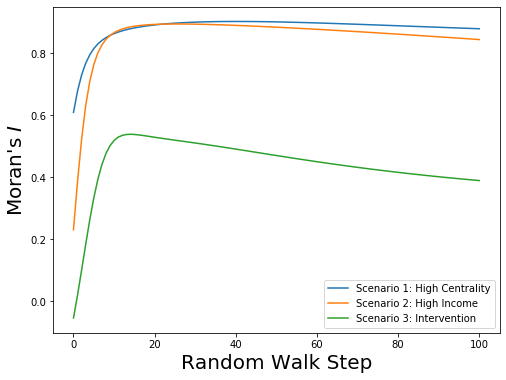

In [30]:
fig4 = plt.figure(figsize=(8,6))
ax4 = fig4.add_subplot(111)
Mr_I_all_df.plot(ax=ax4)
ax4.set_xlabel('Random Walk Step', fontsize=20)
ax4.set_ylabel(r"Moran's $I$", fontsize=20)
fig4.savefig('./figs/rand_walk/moranI_v2.png', bbox_inches='tight', dpi=300)

In [33]:
p_I_all_df = pd.DataFrame(data=np.array(p_I_all).T[:101], 
    columns=['Scenario 1: High Centrality', 'Scenario 2: High Income', 'Scenario 3: Intervention'])

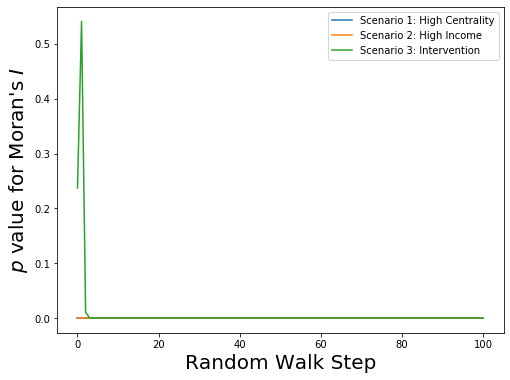

In [34]:
fig5 = plt.figure(figsize=(8,6))
ax5 = fig5.add_subplot(111)
p_I_all_df.plot(ax=ax5)
ax5.set_xlabel('Random Walk Step', fontsize=20)
ax5.set_ylabel(r"$p$ value for Moran's $I$", fontsize=20)
fig5.savefig('./figs/rand_walk/moranIp_v2.png', bbox_inches='tight', dpi=300)

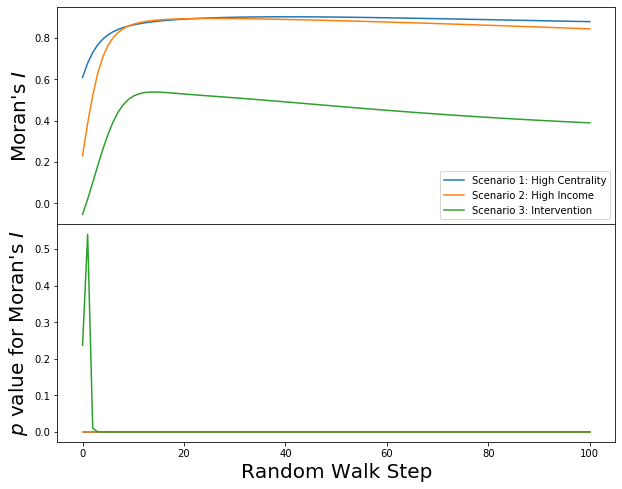

In [35]:
fig6 = plt.figure(figsize=(10,8))
ax61 = fig6.add_subplot(2,1,1)
ax62 = fig6.add_subplot(2,1,2)
fig6.subplots_adjust(hspace=0)
Mr_I_all_df.plot(ax=ax61)
# ax61.set_xlabel('Random Walk Step', fontsize=20)
ax61.set_ylabel(r"Moran's $I$", fontsize=20)
p_I_all_df.plot(ax=ax62, legend=False)
ax62.set_xlabel('Random Walk Step', fontsize=20)
ax62.set_ylabel(r"$p$ value for Moran's $I$", fontsize=20)
fig6.savefig('./figs/rand_walk/moranIp_all_v2.png', bbox_inches='tight', dpi=300)